In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
# sys.version

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

2024-08-05 17:03:38.353977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading the data

In [2]:
input_texts = []
target_texts = []

In [3]:
for line in open("../poetry_generator/data/robert_frost.txt"):
    line = line.rstrip()
    if not line:
        continue
        
    input_line = '<sos> ' + line
    target_line = line + ' <eos>'
    
    input_texts.append(input_line)
    target_texts.append(target_line)

In [4]:
all_lines = input_texts + target_texts
all_lines[:15]

['<sos> Two roads diverged in a yellow wood,',
 '<sos> And sorry I could not travel both',
 '<sos> And be one traveler, long I stood',
 '<sos> And looked down one as far as I could',
 '<sos> To where it bent in the undergrowth;',
 '<sos> Then took the other, as just as fair,',
 '<sos> And having perhaps the better claim',
 '<sos> Because it was grassy and wanted wear,',
 '<sos> Though as for that the passing there',
 '<sos> Had worn them really about the same,',
 '<sos> And both that morning equally lay',
 '<sos> In leaves no step had trodden black.',
 '<sos> Oh, I kept the first for another day!',
 '<sos> Yet knowing how way leads on to way',
 '<sos> I doubted if I should ever come back.']

In [5]:
len(all_lines)

2872

### Converting sentences into integers and word to integer mapping
#### Tokenizer 1) Splits into individual tokens/words 2) each word is converted into an integer index for mapping 

In [6]:
from keras.preprocessing.text import Tokenizer

MAX_VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 100

In [7]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)

# converting words/texts in sentences into a sequence of integers
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

target_sequences[:15]

[[104, 537, 538, 9, 7, 539, 540, 2],
 [5, 541, 6, 65, 31, 934, 141, 2],
 [5, 27, 24, 935, 152, 6, 221, 2],
 [5, 167, 67, 24, 17, 128, 17, 6, 65, 2],
 [4, 40, 11, 936, 9, 3, 937, 2],
 [91, 189, 3, 542, 17, 77, 17, 938, 2],
 [5, 142, 265, 3, 222, 939, 2],
 [319, 11, 14, 543, 5, 223, 940, 2],
 [122, 17, 15, 13, 3, 544, 55, 2],
 [23, 545, 52, 404, 111, 3, 546, 2],
 [5, 141, 13, 941, 942, 405, 2],
 [9, 943, 42, 547, 23, 944, 548, 2],
 [549, 6, 266, 3, 224, 15, 267, 945, 2],
 [153, 946, 92, 81, 947, 18, 4, 81, 2],
 [6, 948, 28, 6, 123, 154, 78, 268, 2]]

In [8]:
print(input_sequences[:15])

max_seq_len_from_data = max(len(s) for s in input_sequences)
print('Maximum sequence length', max_seq_len_from_data)


[[1, 104, 537, 538, 9, 7, 539, 540], [1, 5, 541, 6, 65, 31, 934, 141], [1, 5, 27, 24, 935, 152, 6, 221], [1, 5, 167, 67, 24, 17, 128, 17, 6, 65], [1, 4, 40, 11, 936, 9, 3, 937], [1, 91, 189, 3, 542, 17, 77, 17, 938], [1, 5, 142, 265, 3, 222, 939], [1, 319, 11, 14, 543, 5, 223, 940], [1, 122, 17, 15, 13, 3, 544, 55], [1, 23, 545, 52, 404, 111, 3, 546], [1, 5, 141, 13, 941, 942, 405], [1, 9, 943, 42, 547, 23, 944, 548], [1, 549, 6, 266, 3, 224, 15, 267, 945], [1, 153, 946, 92, 81, 947, 18, 4, 81], [1, 6, 948, 28, 6, 123, 154, 78, 268]]
Maximum sequence length 12


#### word to integer mapping

In [9]:
word_to_index = tokenizer.word_index
print('unique tokens =',len(word_to_index))
assert('<sos>' in word_to_index)
assert('<eos>' in word_to_index)

unique tokens = 3056


### Padding sequences --> by adding padding tokens, all sequences of varying lengths have same length so that they can be effectively processed by the model

In [10]:
max_seq_len = min(max_seq_len_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_seq_len, padding='post')

In [11]:
print('Input sequence is {} with the size of {}' .format(input_sequences[0], input_sequences.shape[1]))
print('Target sequence is {} with the size of {}' .format(target_sequences[0], target_sequences.shape[1]))

Input sequence is [  1 104 537 538   9   7 539 540   0   0   0   0] with the size of 12
Target sequence is [104 537 538   9   7 539 540   2   0   0   0   0] with the size of 12


### Load pre-trained word vectors with GloVe and word --> vec mapping

In [12]:
path2glove = os.getcwd() + '/glove/glove.6B.50d.txt'

In [13]:
word2vec = {}
with open(path2glove) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        
    print('Found {} word vectors.' .format(len(word2vec)))

Found 400000 word vectors.


In [14]:
from itertools import islice

word2vec_first_3 = dict(islice(word2vec.items(), 3))

print(word2vec_first_3)

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32), ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
       -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
       -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
       -0.41634 , -0.1542

### Embedding matrix

In [15]:
print('Filling pretrained embeddings...')

Filling pretrained embeddings...


In [16]:
EMBEDDING_DIM = 50

num_words = min(MAX_VOCAB_SIZE, len(word_to_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [17]:
print(embedding_matrix.shape)
embedding_matrix

(3000, 50)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00

### One-hot encoded target 

#### The target is a sequence, so can not pass a sparse categorical cross entropy loss function to keras as I have multiple targets per input

In [18]:
print(input_sequences.shape)
print(max_seq_len)
print(num_words)

(1436, 12)
12
3000


In [19]:
one_hot_targets = np.zeros((len(input_sequences), max_seq_len, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [20]:
one_hot_targets[3][0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Load pre-trained word embeddings into an Embedding layer

In [21]:
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            weights=[embedding_matrix])

### 1) Training the language model to predict the next word in the sentence by memorizing a bunch of sentences..

### Create an LSTM network with a single LSTM

#### Building a model...

In [22]:
from keras.layers import Dense, Embedding, Input, LSTM

LATENT_DIM = 25
BATCH_SIZE = 128
EPOCHS = 4000
VALIDATION_SPLIT = 0.2

In [23]:
input_ = Input(shape = (max_seq_len,))
input_h = Input(shape = (LATENT_DIM,))
input_c = Input(shape = (LATENT_DIM,))

In [24]:
x = embedding_layer(input_)

# LSTM has to predict rest of the sequence and the output must be a sequence, hence return_sequences=True
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[input_h, input_c])

dense = Dense(num_words, activation='softmax')
output = dense(x)

2024-08-05 17:03:50.438109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
model = Model([input_, input_h, input_c], output)
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy'])

In [26]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit([input_sequences, z, z],
             one_hot_targets,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             validation_split=VALIDATION_SPLIT)

Training model...
Epoch 1/4000
9/9 [==============================] - 4s 171ms/step - loss: 5.3898 - accuracy: 0.0089 - val_loss: 5.0469 - val_accuracy: 0.0191
Epoch 2/4000
9/9 [==============================] - 1s 99ms/step - loss: 4.6058 - accuracy: 0.0382 - val_loss: 4.7318 - val_accuracy: 0.0833
Epoch 3/4000
9/9 [==============================] - 1s 99ms/step - loss: 4.3708 - accuracy: 0.0833 - val_loss: 4.7999 - val_accuracy: 0.0833
Epoch 4/4000
9/9 [==============================] - 1s 97ms/step - loss: 4.3280 - accuracy: 0.0833 - val_loss: 4.8228 - val_accuracy: 0.0833
Epoch 5/4000
9/9 [==============================] - 1s 98ms/step - loss: 4.3178 - accuracy: 0.0833 - val_loss: 4.8075 - val_accuracy: 0.0833
Epoch 6/4000
9/9 [==============================] - 1s 98ms/step - loss: 4.2844 - accuracy: 0.0833 - val_loss: 4.7412 - val_accuracy: 0.0833
Epoch 7/4000
9/9 [==============================] - 1s 102ms/step - loss: 4.2375 - accuracy: 0.0833 - val_loss: 4.6817 - val_accuracy: 

9/9 [==============================] - 1s 99ms/step - loss: 2.9379 - accuracy: 0.1863 - val_loss: 4.8550 - val_accuracy: 0.0900
Epoch 59/4000
9/9 [==============================] - 1s 101ms/step - loss: 2.9164 - accuracy: 0.1881 - val_loss: 4.8628 - val_accuracy: 0.0909
Epoch 60/4000
9/9 [==============================] - 1s 101ms/step - loss: 2.9038 - accuracy: 0.1900 - val_loss: 4.8710 - val_accuracy: 0.0917
Epoch 61/4000
9/9 [==============================] - 1s 99ms/step - loss: 2.8873 - accuracy: 0.1896 - val_loss: 4.8833 - val_accuracy: 0.0894
Epoch 62/4000
9/9 [==============================] - 1s 98ms/step - loss: 2.8707 - accuracy: 0.1939 - val_loss: 4.8911 - val_accuracy: 0.0909
Epoch 63/4000
9/9 [==============================] - 1s 101ms/step - loss: 2.8553 - accuracy: 0.1928 - val_loss: 4.9043 - val_accuracy: 0.0900
Epoch 64/4000
9/9 [==============================] - 1s 98ms/step - loss: 2.8399 - accuracy: 0.1982 - val_loss: 4.9151 - val_accuracy: 0.0909
Epoch 65/4000
9/9

9/9 [==============================] - 1s 98ms/step - loss: 2.2237 - accuracy: 0.2613 - val_loss: 5.5355 - val_accuracy: 0.0813
Epoch 116/4000
9/9 [==============================] - 1s 138ms/step - loss: 2.2166 - accuracy: 0.2613 - val_loss: 5.5547 - val_accuracy: 0.0830
Epoch 117/4000
9/9 [==============================] - 1s 107ms/step - loss: 2.2078 - accuracy: 0.2641 - val_loss: 5.5746 - val_accuracy: 0.0836
Epoch 118/4000
9/9 [==============================] - 1s 98ms/step - loss: 2.2003 - accuracy: 0.2623 - val_loss: 5.5830 - val_accuracy: 0.0839
Epoch 119/4000
9/9 [==============================] - 1s 95ms/step - loss: 2.1944 - accuracy: 0.2642 - val_loss: 5.5870 - val_accuracy: 0.0828
Epoch 120/4000
9/9 [==============================] - 1s 96ms/step - loss: 2.1858 - accuracy: 0.2655 - val_loss: 5.6171 - val_accuracy: 0.0833
Epoch 121/4000
9/9 [==============================] - 1s 95ms/step - loss: 2.1767 - accuracy: 0.2687 - val_loss: 5.6098 - val_accuracy: 0.0842
Epoch 122/40

9/9 [==============================] - 1s 100ms/step - loss: 1.9044 - accuracy: 0.3071 - val_loss: 6.3746 - val_accuracy: 0.0787
Epoch 173/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.8998 - accuracy: 0.3095 - val_loss: 6.3873 - val_accuracy: 0.0796
Epoch 174/4000
9/9 [==============================] - 1s 96ms/step - loss: 1.8913 - accuracy: 0.3110 - val_loss: 6.4173 - val_accuracy: 0.0770
Epoch 175/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.8848 - accuracy: 0.3105 - val_loss: 6.4557 - val_accuracy: 0.0775
Epoch 176/4000
9/9 [==============================] - 1s 96ms/step - loss: 1.8800 - accuracy: 0.3116 - val_loss: 6.4518 - val_accuracy: 0.0784
Epoch 177/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.8714 - accuracy: 0.3148 - val_loss: 6.4721 - val_accuracy: 0.0767
Epoch 178/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.8683 - accuracy: 0.3153 - val_loss: 6.4659 - val_accuracy: 0.0761
Epoch 179/400

9/9 [==============================] - 1s 98ms/step - loss: 1.6572 - accuracy: 0.3548 - val_loss: 7.2606 - val_accuracy: 0.0770
Epoch 230/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.6514 - accuracy: 0.3531 - val_loss: 7.2800 - val_accuracy: 0.0773
Epoch 231/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.6490 - accuracy: 0.3561 - val_loss: 7.2863 - val_accuracy: 0.0775
Epoch 232/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.6449 - accuracy: 0.3531 - val_loss: 7.2914 - val_accuracy: 0.0770
Epoch 233/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.6441 - accuracy: 0.3556 - val_loss: 7.3295 - val_accuracy: 0.0767
Epoch 234/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.6434 - accuracy: 0.3561 - val_loss: 7.3092 - val_accuracy: 0.0755
Epoch 235/4000
9/9 [==============================] - 1s 106ms/step - loss: 1.6400 - accuracy: 0.3564 - val_loss: 7.3185 - val_accuracy: 0.0767
Epoch 236/400

9/9 [==============================] - 1s 98ms/step - loss: 1.4786 - accuracy: 0.3894 - val_loss: 8.1071 - val_accuracy: 0.0729
Epoch 287/4000
9/9 [==============================] - 1s 96ms/step - loss: 1.4805 - accuracy: 0.3908 - val_loss: 8.1424 - val_accuracy: 0.0720
Epoch 288/4000
9/9 [==============================] - 1s 96ms/step - loss: 1.4809 - accuracy: 0.3883 - val_loss: 8.1696 - val_accuracy: 0.0718
Epoch 289/4000
9/9 [==============================] - 1s 96ms/step - loss: 1.4748 - accuracy: 0.3877 - val_loss: 8.2040 - val_accuracy: 0.0738
Epoch 290/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.4734 - accuracy: 0.3929 - val_loss: 8.1702 - val_accuracy: 0.0723
Epoch 291/4000
9/9 [==============================] - 1s 118ms/step - loss: 1.4703 - accuracy: 0.3927 - val_loss: 8.1995 - val_accuracy: 0.0712
Epoch 292/4000
9/9 [==============================] - 1s 95ms/step - loss: 1.4653 - accuracy: 0.3918 - val_loss: 8.2508 - val_accuracy: 0.0723
Epoch 293/400

9/9 [==============================] - 1s 97ms/step - loss: 1.3552 - accuracy: 0.4163 - val_loss: 9.0964 - val_accuracy: 0.0720
Epoch 344/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.3511 - accuracy: 0.4154 - val_loss: 9.0621 - val_accuracy: 0.0723
Epoch 345/4000
9/9 [==============================] - 1s 100ms/step - loss: 1.3487 - accuracy: 0.4178 - val_loss: 9.1361 - val_accuracy: 0.0694
Epoch 346/4000
9/9 [==============================] - 1s 104ms/step - loss: 1.3468 - accuracy: 0.4189 - val_loss: 9.1427 - val_accuracy: 0.0720
Epoch 347/4000
9/9 [==============================] - 1s 99ms/step - loss: 1.3476 - accuracy: 0.4157 - val_loss: 9.1840 - val_accuracy: 0.0712
Epoch 348/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.3440 - accuracy: 0.4196 - val_loss: 9.1853 - val_accuracy: 0.0706
Epoch 349/4000
9/9 [==============================] - 1s 111ms/step - loss: 1.3414 - accuracy: 0.4183 - val_loss: 9.1755 - val_accuracy: 0.0706
Epoch 350/4

9/9 [==============================] - 1s 97ms/step - loss: 1.2512 - accuracy: 0.4373 - val_loss: 10.0601 - val_accuracy: 0.0726
Epoch 401/4000
9/9 [==============================] - 1s 99ms/step - loss: 1.2557 - accuracy: 0.4335 - val_loss: 10.0032 - val_accuracy: 0.0720
Epoch 402/4000
9/9 [==============================] - 1s 100ms/step - loss: 1.2567 - accuracy: 0.4348 - val_loss: 10.0482 - val_accuracy: 0.0720
Epoch 403/4000
9/9 [==============================] - 1s 99ms/step - loss: 1.2586 - accuracy: 0.4334 - val_loss: 10.0344 - val_accuracy: 0.0700
Epoch 404/4000
9/9 [==============================] - 1s 105ms/step - loss: 1.2567 - accuracy: 0.4318 - val_loss: 10.1194 - val_accuracy: 0.0712
Epoch 405/4000
9/9 [==============================] - 1s 100ms/step - loss: 1.2607 - accuracy: 0.4301 - val_loss: 10.0816 - val_accuracy: 0.0706
Epoch 406/4000
9/9 [==============================] - 1s 106ms/step - loss: 1.2605 - accuracy: 0.4321 - val_loss: 10.0747 - val_accuracy: 0.0709
Epo

Epoch 457/4000
9/9 [==============================] - 1s 108ms/step - loss: 1.1826 - accuracy: 0.4504 - val_loss: 10.7954 - val_accuracy: 0.0712
Epoch 458/4000
9/9 [==============================] - 1s 108ms/step - loss: 1.1762 - accuracy: 0.4490 - val_loss: 10.8262 - val_accuracy: 0.0712
Epoch 459/4000
9/9 [==============================] - 1s 110ms/step - loss: 1.1709 - accuracy: 0.4540 - val_loss: 10.8434 - val_accuracy: 0.0694
Epoch 460/4000
9/9 [==============================] - 1s 105ms/step - loss: 1.1626 - accuracy: 0.4548 - val_loss: 10.8322 - val_accuracy: 0.0703
Epoch 461/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.1619 - accuracy: 0.4539 - val_loss: 10.8564 - val_accuracy: 0.0694
Epoch 462/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.1586 - accuracy: 0.4589 - val_loss: 10.8887 - val_accuracy: 0.0700
Epoch 463/4000
9/9 [==============================] - 1s 96ms/step - loss: 1.1682 - accuracy: 0.4535 - val_loss: 10.9073 - val_accur

Epoch 514/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.1146 - accuracy: 0.4636 - val_loss: 11.6181 - val_accuracy: 0.0712
Epoch 515/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.1176 - accuracy: 0.4623 - val_loss: 11.6445 - val_accuracy: 0.0709
Epoch 516/4000
9/9 [==============================] - 1s 95ms/step - loss: 1.1153 - accuracy: 0.4636 - val_loss: 11.6732 - val_accuracy: 0.0706
Epoch 517/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.1167 - accuracy: 0.4620 - val_loss: 11.7197 - val_accuracy: 0.0709
Epoch 518/4000
9/9 [==============================] - 1s 96ms/step - loss: 1.1161 - accuracy: 0.4634 - val_loss: 11.7319 - val_accuracy: 0.0706
Epoch 519/4000
9/9 [==============================] - 1s 99ms/step - loss: 1.1160 - accuracy: 0.4633 - val_loss: 11.7100 - val_accuracy: 0.0709
Epoch 520/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.1103 - accuracy: 0.4639 - val_loss: 11.6212 - val_accuracy:

Epoch 571/4000
9/9 [==============================] - 1s 100ms/step - loss: 1.0735 - accuracy: 0.4684 - val_loss: 12.4350 - val_accuracy: 0.0683
Epoch 572/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.0778 - accuracy: 0.4661 - val_loss: 12.4708 - val_accuracy: 0.0680
Epoch 573/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.0673 - accuracy: 0.4711 - val_loss: 12.3643 - val_accuracy: 0.0677
Epoch 574/4000
9/9 [==============================] - 1s 99ms/step - loss: 1.0576 - accuracy: 0.4716 - val_loss: 12.3501 - val_accuracy: 0.0686
Epoch 575/4000
9/9 [==============================] - 1s 168ms/step - loss: 1.0560 - accuracy: 0.4740 - val_loss: 12.3971 - val_accuracy: 0.0680
Epoch 576/4000
9/9 [==============================] - 1s 123ms/step - loss: 1.0580 - accuracy: 0.4712 - val_loss: 12.4176 - val_accuracy: 0.0706
Epoch 577/4000
9/9 [==============================] - 1s 105ms/step - loss: 1.0587 - accuracy: 0.4716 - val_loss: 12.4852 - val_accur

Epoch 628/4000
9/9 [==============================] - 1s 95ms/step - loss: 1.0231 - accuracy: 0.4789 - val_loss: 13.2268 - val_accuracy: 0.0692
Epoch 629/4000
9/9 [==============================] - 1s 96ms/step - loss: 1.0219 - accuracy: 0.4774 - val_loss: 13.1965 - val_accuracy: 0.0692
Epoch 630/4000
9/9 [==============================] - 1s 97ms/step - loss: 1.0196 - accuracy: 0.4797 - val_loss: 13.2319 - val_accuracy: 0.0683
Epoch 631/4000
9/9 [==============================] - 1s 102ms/step - loss: 1.0176 - accuracy: 0.4775 - val_loss: 13.1872 - val_accuracy: 0.0692
Epoch 632/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.0158 - accuracy: 0.4786 - val_loss: 13.2289 - val_accuracy: 0.0666
Epoch 633/4000
9/9 [==============================] - 1s 95ms/step - loss: 1.0221 - accuracy: 0.4776 - val_loss: 13.2450 - val_accuracy: 0.0677
Epoch 634/4000
9/9 [==============================] - 1s 99ms/step - loss: 1.0215 - accuracy: 0.4783 - val_loss: 13.2591 - val_accuracy

Epoch 685/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.9923 - accuracy: 0.4816 - val_loss: 14.0077 - val_accuracy: 0.0677
Epoch 686/4000
9/9 [==============================] - 1s 97ms/step - loss: 0.9989 - accuracy: 0.4788 - val_loss: 13.9534 - val_accuracy: 0.0692
Epoch 687/4000
9/9 [==============================] - 1s 107ms/step - loss: 0.9995 - accuracy: 0.4829 - val_loss: 14.0354 - val_accuracy: 0.0677
Epoch 688/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.9941 - accuracy: 0.4832 - val_loss: 13.9888 - val_accuracy: 0.0680
Epoch 689/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.9919 - accuracy: 0.4829 - val_loss: 14.0119 - val_accuracy: 0.0686
Epoch 690/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.9957 - accuracy: 0.4835 - val_loss: 14.0532 - val_accuracy: 0.0657
Epoch 691/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.9907 - accuracy: 0.4841 - val_loss: 14.0310 - val_accura

9/9 [==============================] - 1s 102ms/step - loss: 0.9831 - accuracy: 0.4845 - val_loss: 14.6392 - val_accuracy: 0.0651
Epoch 742/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.9789 - accuracy: 0.4837 - val_loss: 14.6959 - val_accuracy: 0.0639
Epoch 743/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.9833 - accuracy: 0.4842 - val_loss: 14.7602 - val_accuracy: 0.0657
Epoch 744/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9822 - accuracy: 0.4816 - val_loss: 14.7468 - val_accuracy: 0.0654
Epoch 745/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.9702 - accuracy: 0.4849 - val_loss: 14.7847 - val_accuracy: 0.0654
Epoch 746/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9610 - accuracy: 0.4897 - val_loss: 14.7813 - val_accuracy: 0.0651
Epoch 747/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.9632 - accuracy: 0.4890 - val_loss: 14.7161 - val_accuracy: 0.0663
Ep

Epoch 798/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9227 - accuracy: 0.4999 - val_loss: 15.4156 - val_accuracy: 0.0637
Epoch 799/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.9262 - accuracy: 0.5016 - val_loss: 15.3899 - val_accuracy: 0.0634
Epoch 800/4000
9/9 [==============================] - 1s 110ms/step - loss: 0.9245 - accuracy: 0.4992 - val_loss: 15.3217 - val_accuracy: 0.0634
Epoch 801/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9289 - accuracy: 0.4989 - val_loss: 15.4230 - val_accuracy: 0.0639
Epoch 802/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9264 - accuracy: 0.4993 - val_loss: 15.4043 - val_accuracy: 0.0628
Epoch 803/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9228 - accuracy: 0.5007 - val_loss: 15.3658 - val_accuracy: 0.0622
Epoch 804/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9224 - accuracy: 0.4977 - val_loss: 15.4367 - val_ac

9/9 [==============================] - 1s 107ms/step - loss: 0.9136 - accuracy: 0.5027 - val_loss: 16.0988 - val_accuracy: 0.0625
Epoch 855/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9107 - accuracy: 0.5007 - val_loss: 16.0623 - val_accuracy: 0.0616
Epoch 856/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.9053 - accuracy: 0.5005 - val_loss: 16.0833 - val_accuracy: 0.0625
Epoch 857/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9172 - accuracy: 0.4987 - val_loss: 16.1375 - val_accuracy: 0.0625
Epoch 858/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9223 - accuracy: 0.4969 - val_loss: 16.0732 - val_accuracy: 0.0619
Epoch 859/4000
9/9 [==============================] - 1s 113ms/step - loss: 0.9281 - accuracy: 0.4963 - val_loss: 16.1801 - val_accuracy: 0.0613
Epoch 860/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.9248 - accuracy: 0.4966 - val_loss: 16.1458 - val_accuracy: 0.0593


9/9 [==============================] - 1s 105ms/step - loss: 0.8988 - accuracy: 0.5024 - val_loss: 16.8279 - val_accuracy: 0.0605
Epoch 911/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.9019 - accuracy: 0.5021 - val_loss: 16.8478 - val_accuracy: 0.0619
Epoch 912/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.9116 - accuracy: 0.5003 - val_loss: 16.8671 - val_accuracy: 0.0599
Epoch 913/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.9145 - accuracy: 0.4978 - val_loss: 16.7143 - val_accuracy: 0.0611
Epoch 914/4000
9/9 [==============================] - 1s 112ms/step - loss: 0.9131 - accuracy: 0.4993 - val_loss: 16.7719 - val_accuracy: 0.0596
Epoch 915/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.9170 - accuracy: 0.4995 - val_loss: 16.7770 - val_accuracy: 0.0622
Epoch 916/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.9109 - accuracy: 0.4991 - val_loss: 16.7420 - val_accuracy: 0.0622


9/9 [==============================] - 1s 107ms/step - loss: 0.8862 - accuracy: 0.5045 - val_loss: 17.3032 - val_accuracy: 0.0619
Epoch 967/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8832 - accuracy: 0.5040 - val_loss: 17.3936 - val_accuracy: 0.0605
Epoch 968/4000
9/9 [==============================] - 1s 112ms/step - loss: 0.8863 - accuracy: 0.5040 - val_loss: 17.3784 - val_accuracy: 0.0599
Epoch 969/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8887 - accuracy: 0.5044 - val_loss: 17.4395 - val_accuracy: 0.0599
Epoch 970/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8845 - accuracy: 0.5024 - val_loss: 17.4352 - val_accuracy: 0.0611
Epoch 971/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8842 - accuracy: 0.5022 - val_loss: 17.3806 - val_accuracy: 0.0619
Epoch 972/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8845 - accuracy: 0.5060 - val_loss: 17.4220 - val_accuracy: 0.0593


9/9 [==============================] - 1s 104ms/step - loss: 0.9088 - accuracy: 0.4981 - val_loss: 18.0586 - val_accuracy: 0.0593
Epoch 1023/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8964 - accuracy: 0.4986 - val_loss: 18.1648 - val_accuracy: 0.0584
Epoch 1024/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.8911 - accuracy: 0.5037 - val_loss: 18.1352 - val_accuracy: 0.0579
Epoch 1025/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8890 - accuracy: 0.5025 - val_loss: 18.1369 - val_accuracy: 0.0576
Epoch 1026/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8931 - accuracy: 0.5030 - val_loss: 17.9780 - val_accuracy: 0.0602
Epoch 1027/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8857 - accuracy: 0.5030 - val_loss: 18.1815 - val_accuracy: 0.0590
Epoch 1028/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8790 - accuracy: 0.5063 - val_loss: 18.1512 - val_accuracy: 0

9/9 [==============================] - 1s 109ms/step - loss: 0.9552 - accuracy: 0.4842 - val_loss: 18.6631 - val_accuracy: 0.0602
Epoch 1079/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.9407 - accuracy: 0.4878 - val_loss: 18.5047 - val_accuracy: 0.0625
Epoch 1080/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9595 - accuracy: 0.4836 - val_loss: 18.8451 - val_accuracy: 0.0590
Epoch 1081/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9803 - accuracy: 0.4820 - val_loss: 18.7179 - val_accuracy: 0.0605
Epoch 1082/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.9639 - accuracy: 0.4837 - val_loss: 18.6730 - val_accuracy: 0.0628
Epoch 1083/4000
9/9 [==============================] - 1s 108ms/step - loss: 0.9535 - accuracy: 0.4851 - val_loss: 18.7186 - val_accuracy: 0.0608
Epoch 1084/4000
9/9 [==============================] - 1s 107ms/step - loss: 0.9491 - accuracy: 0.4881 - val_loss: 18.8844 - val_accuracy: 0

9/9 [==============================] - 1s 111ms/step - loss: 0.8620 - accuracy: 0.5094 - val_loss: 19.6026 - val_accuracy: 0.0582
Epoch 1135/4000
9/9 [==============================] - 1s 108ms/step - loss: 0.8732 - accuracy: 0.5076 - val_loss: 19.4920 - val_accuracy: 0.0579
Epoch 1136/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8653 - accuracy: 0.5078 - val_loss: 19.5878 - val_accuracy: 0.0579
Epoch 1137/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8607 - accuracy: 0.5096 - val_loss: 19.5189 - val_accuracy: 0.0579
Epoch 1138/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8646 - accuracy: 0.5070 - val_loss: 19.5094 - val_accuracy: 0.0573
Epoch 1139/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8661 - accuracy: 0.5069 - val_loss: 19.3897 - val_accuracy: 0.0584
Epoch 1140/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8640 - accuracy: 0.5090 - val_loss: 19.5843 - val_accuracy: 0

9/9 [==============================] - 1s 100ms/step - loss: 0.9012 - accuracy: 0.4993 - val_loss: 20.0431 - val_accuracy: 0.0587
Epoch 1191/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9052 - accuracy: 0.4991 - val_loss: 20.2012 - val_accuracy: 0.0576
Epoch 1192/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8858 - accuracy: 0.5023 - val_loss: 20.0599 - val_accuracy: 0.0570
Epoch 1193/4000
9/9 [==============================] - 1s 107ms/step - loss: 0.8836 - accuracy: 0.5017 - val_loss: 20.1080 - val_accuracy: 0.0564
Epoch 1194/4000
9/9 [==============================] - 1s 111ms/step - loss: 0.8779 - accuracy: 0.5048 - val_loss: 20.2779 - val_accuracy: 0.0561
Epoch 1195/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8692 - accuracy: 0.5071 - val_loss: 20.2066 - val_accuracy: 0.0558
Epoch 1196/4000
9/9 [==============================] - 1s 118ms/step - loss: 0.8806 - accuracy: 0.5068 - val_loss: 20.2768 - val_accuracy: 0

9/9 [==============================] - 1s 100ms/step - loss: 0.8525 - accuracy: 0.5134 - val_loss: 20.7924 - val_accuracy: 0.0556
Epoch 1247/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8482 - accuracy: 0.5141 - val_loss: 20.9100 - val_accuracy: 0.0538
Epoch 1248/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8409 - accuracy: 0.5165 - val_loss: 20.8527 - val_accuracy: 0.0558
Epoch 1249/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8508 - accuracy: 0.5135 - val_loss: 20.8235 - val_accuracy: 0.0550
Epoch 1250/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8619 - accuracy: 0.5095 - val_loss: 20.8590 - val_accuracy: 0.0561
Epoch 1251/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8645 - accuracy: 0.5098 - val_loss: 21.0214 - val_accuracy: 0.0550
Epoch 1252/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8583 - accuracy: 0.5089 - val_loss: 20.9185 - val_accuracy: 0

9/9 [==============================] - 1s 101ms/step - loss: 0.9576 - accuracy: 0.4829 - val_loss: 21.3675 - val_accuracy: 0.0535
Epoch 1303/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.9295 - accuracy: 0.4898 - val_loss: 21.5021 - val_accuracy: 0.0553
Epoch 1304/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.9093 - accuracy: 0.4962 - val_loss: 21.4372 - val_accuracy: 0.0538
Epoch 1305/4000
9/9 [==============================] - 1s 121ms/step - loss: 0.8865 - accuracy: 0.5028 - val_loss: 21.2643 - val_accuracy: 0.0553
Epoch 1306/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8752 - accuracy: 0.5060 - val_loss: 21.5812 - val_accuracy: 0.0550
Epoch 1307/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8673 - accuracy: 0.5078 - val_loss: 21.5074 - val_accuracy: 0.0544
Epoch 1308/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8697 - accuracy: 0.5072 - val_loss: 21.4764 - val_accuracy: 0

9/9 [==============================] - 1s 103ms/step - loss: 0.8608 - accuracy: 0.5083 - val_loss: 22.1083 - val_accuracy: 0.0527
Epoch 1359/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8654 - accuracy: 0.5086 - val_loss: 22.1717 - val_accuracy: 0.0524
Epoch 1360/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8535 - accuracy: 0.5108 - val_loss: 21.9730 - val_accuracy: 0.0532
Epoch 1361/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8665 - accuracy: 0.5086 - val_loss: 22.2221 - val_accuracy: 0.0524
Epoch 1362/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8865 - accuracy: 0.5047 - val_loss: 22.0143 - val_accuracy: 0.0538
Epoch 1363/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8776 - accuracy: 0.5055 - val_loss: 22.3142 - val_accuracy: 0.0538
Epoch 1364/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8831 - accuracy: 0.5017 - val_loss: 22.0696 - val_accuracy: 0

9/9 [==============================] - 1s 104ms/step - loss: 0.8646 - accuracy: 0.5092 - val_loss: 22.7174 - val_accuracy: 0.0547
Epoch 1415/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.8610 - accuracy: 0.5057 - val_loss: 22.7392 - val_accuracy: 0.0561
Epoch 1416/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8619 - accuracy: 0.5099 - val_loss: 22.8569 - val_accuracy: 0.0547
Epoch 1417/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8606 - accuracy: 0.5074 - val_loss: 22.8340 - val_accuracy: 0.0538
Epoch 1418/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8568 - accuracy: 0.5101 - val_loss: 22.8037 - val_accuracy: 0.0553
Epoch 1419/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8541 - accuracy: 0.5108 - val_loss: 22.8176 - val_accuracy: 0.0547
Epoch 1420/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8591 - accuracy: 0.5107 - val_loss: 22.9748 - val_accuracy: 0

9/9 [==============================] - 1s 103ms/step - loss: 0.8467 - accuracy: 0.5154 - val_loss: 23.2920 - val_accuracy: 0.0553
Epoch 1471/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8495 - accuracy: 0.5138 - val_loss: 23.3617 - val_accuracy: 0.0561
Epoch 1472/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.8490 - accuracy: 0.5114 - val_loss: 23.6061 - val_accuracy: 0.0550
Epoch 1473/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8476 - accuracy: 0.5112 - val_loss: 23.4997 - val_accuracy: 0.0564
Epoch 1474/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8467 - accuracy: 0.5118 - val_loss: 23.2905 - val_accuracy: 0.0541
Epoch 1475/4000
9/9 [==============================] - 1s 116ms/step - loss: 0.8765 - accuracy: 0.5067 - val_loss: 23.5615 - val_accuracy: 0.0564
Epoch 1476/4000
9/9 [==============================] - 1s 116ms/step - loss: 0.8899 - accuracy: 0.5010 - val_loss: 23.3647 - val_accuracy: 0

9/9 [==============================] - 1s 103ms/step - loss: 0.9168 - accuracy: 0.4930 - val_loss: 23.8445 - val_accuracy: 0.0538
Epoch 1527/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9222 - accuracy: 0.4925 - val_loss: 23.8570 - val_accuracy: 0.0538
Epoch 1528/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.9281 - accuracy: 0.4897 - val_loss: 24.1493 - val_accuracy: 0.0564
Epoch 1529/4000
9/9 [==============================] - 1s 114ms/step - loss: 0.9800 - accuracy: 0.4809 - val_loss: 23.9288 - val_accuracy: 0.0553
Epoch 1530/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9692 - accuracy: 0.4813 - val_loss: 23.9146 - val_accuracy: 0.0564
Epoch 1531/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9554 - accuracy: 0.4841 - val_loss: 23.9314 - val_accuracy: 0.0579
Epoch 1532/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.9458 - accuracy: 0.4890 - val_loss: 23.9395 - val_accuracy: 0

9/9 [==============================] - 1s 101ms/step - loss: 0.8411 - accuracy: 0.5144 - val_loss: 24.7080 - val_accuracy: 0.0558
Epoch 1583/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8591 - accuracy: 0.5093 - val_loss: 24.7410 - val_accuracy: 0.0532
Epoch 1584/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8540 - accuracy: 0.5091 - val_loss: 24.7215 - val_accuracy: 0.0558
Epoch 1585/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8651 - accuracy: 0.5046 - val_loss: 24.7422 - val_accuracy: 0.0564
Epoch 1586/4000
9/9 [==============================] - 1s 108ms/step - loss: 0.8631 - accuracy: 0.5065 - val_loss: 24.7377 - val_accuracy: 0.0550
Epoch 1587/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8571 - accuracy: 0.5088 - val_loss: 24.6911 - val_accuracy: 0.0561
Epoch 1588/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8627 - accuracy: 0.5086 - val_loss: 24.5531 - val_accuracy: 0

9/9 [==============================] - 1s 107ms/step - loss: 0.8727 - accuracy: 0.5055 - val_loss: 25.3596 - val_accuracy: 0.0521
Epoch 1639/4000
9/9 [==============================] - 1s 126ms/step - loss: 0.8692 - accuracy: 0.5068 - val_loss: 25.3294 - val_accuracy: 0.0530
Epoch 1640/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8701 - accuracy: 0.5046 - val_loss: 25.1081 - val_accuracy: 0.0541
Epoch 1641/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8723 - accuracy: 0.5073 - val_loss: 25.1846 - val_accuracy: 0.0527
Epoch 1642/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8724 - accuracy: 0.5054 - val_loss: 25.2493 - val_accuracy: 0.0538
Epoch 1643/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8759 - accuracy: 0.5078 - val_loss: 25.2076 - val_accuracy: 0.0527
Epoch 1644/4000
9/9 [==============================] - 1s 120ms/step - loss: 0.8537 - accuracy: 0.5108 - val_loss: 25.4823 - val_accuracy: 0

9/9 [==============================] - 1s 103ms/step - loss: 0.8460 - accuracy: 0.5146 - val_loss: 25.7367 - val_accuracy: 0.0587
Epoch 1695/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8490 - accuracy: 0.5125 - val_loss: 25.8391 - val_accuracy: 0.0556
Epoch 1696/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8609 - accuracy: 0.5078 - val_loss: 25.6988 - val_accuracy: 0.0567
Epoch 1697/4000
9/9 [==============================] - 1s 113ms/step - loss: 0.8604 - accuracy: 0.5074 - val_loss: 25.6860 - val_accuracy: 0.0576
Epoch 1698/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8576 - accuracy: 0.5094 - val_loss: 25.7459 - val_accuracy: 0.0567
Epoch 1699/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8522 - accuracy: 0.5111 - val_loss: 25.8669 - val_accuracy: 0.0538
Epoch 1700/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8585 - accuracy: 0.5089 - val_loss: 25.8669 - val_accuracy: 0

9/9 [==============================] - 1s 102ms/step - loss: 0.8533 - accuracy: 0.5105 - val_loss: 26.3772 - val_accuracy: 0.0547
Epoch 1751/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8508 - accuracy: 0.5074 - val_loss: 26.3122 - val_accuracy: 0.0576
Epoch 1752/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8611 - accuracy: 0.5067 - val_loss: 26.3790 - val_accuracy: 0.0573
Epoch 1753/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8776 - accuracy: 0.5046 - val_loss: 26.3009 - val_accuracy: 0.0544
Epoch 1754/4000
9/9 [==============================] - 1s 111ms/step - loss: 0.8601 - accuracy: 0.5051 - val_loss: 26.3490 - val_accuracy: 0.0567
Epoch 1755/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8755 - accuracy: 0.5051 - val_loss: 26.5834 - val_accuracy: 0.0547
Epoch 1756/4000
9/9 [==============================] - 1s 118ms/step - loss: 0.8587 - accuracy: 0.5064 - val_loss: 26.3818 - val_accuracy: 0

9/9 [==============================] - 1s 105ms/step - loss: 0.8121 - accuracy: 0.5225 - val_loss: 27.0004 - val_accuracy: 0.0535
Epoch 1807/4000
9/9 [==============================] - 1s 123ms/step - loss: 0.8144 - accuracy: 0.5203 - val_loss: 27.1707 - val_accuracy: 0.0538
Epoch 1808/4000
9/9 [==============================] - 1s 126ms/step - loss: 0.8256 - accuracy: 0.5184 - val_loss: 27.2432 - val_accuracy: 0.0544
Epoch 1809/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8362 - accuracy: 0.5174 - val_loss: 27.0417 - val_accuracy: 0.0558
Epoch 1810/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8295 - accuracy: 0.5176 - val_loss: 27.0776 - val_accuracy: 0.0550
Epoch 1811/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8332 - accuracy: 0.5155 - val_loss: 27.1169 - val_accuracy: 0.0556
Epoch 1812/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8421 - accuracy: 0.5132 - val_loss: 26.9179 - val_accuracy: 0

9/9 [==============================] - 1s 109ms/step - loss: 0.8713 - accuracy: 0.5076 - val_loss: 27.5136 - val_accuracy: 0.0553
Epoch 1863/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8740 - accuracy: 0.5061 - val_loss: 27.6393 - val_accuracy: 0.0556
Epoch 1864/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8892 - accuracy: 0.4982 - val_loss: 27.4690 - val_accuracy: 0.0556
Epoch 1865/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9013 - accuracy: 0.4960 - val_loss: 27.7495 - val_accuracy: 0.0556
Epoch 1866/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9532 - accuracy: 0.4900 - val_loss: 27.3644 - val_accuracy: 0.0573
Epoch 1867/4000
9/9 [==============================] - 1s 103ms/step - loss: 1.0771 - accuracy: 0.4663 - val_loss: 27.4450 - val_accuracy: 0.0590
Epoch 1868/4000
9/9 [==============================] - 1s 105ms/step - loss: 1.0568 - accuracy: 0.4654 - val_loss: 27.4703 - val_accuracy: 0

9/9 [==============================] - 1s 103ms/step - loss: 0.8497 - accuracy: 0.5099 - val_loss: 28.3640 - val_accuracy: 0.0538
Epoch 1919/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8533 - accuracy: 0.5078 - val_loss: 28.3440 - val_accuracy: 0.0553
Epoch 1920/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8436 - accuracy: 0.5115 - val_loss: 27.8630 - val_accuracy: 0.0570
Epoch 1921/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8346 - accuracy: 0.5131 - val_loss: 28.3308 - val_accuracy: 0.0544
Epoch 1922/4000
9/9 [==============================] - 1s 132ms/step - loss: 0.8466 - accuracy: 0.5136 - val_loss: 27.9641 - val_accuracy: 0.0567
Epoch 1923/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.8247 - accuracy: 0.5173 - val_loss: 28.3484 - val_accuracy: 0.0527
Epoch 1924/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8234 - accuracy: 0.5191 - val_loss: 28.2560 - val_accuracy: 0

9/9 [==============================] - 1s 107ms/step - loss: 0.9190 - accuracy: 0.4918 - val_loss: 28.7253 - val_accuracy: 0.0558
Epoch 1975/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.9018 - accuracy: 0.4999 - val_loss: 28.7402 - val_accuracy: 0.0524
Epoch 1976/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8919 - accuracy: 0.4985 - val_loss: 28.9699 - val_accuracy: 0.0506
Epoch 1977/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8790 - accuracy: 0.5054 - val_loss: 28.5417 - val_accuracy: 0.0553
Epoch 1978/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8583 - accuracy: 0.5087 - val_loss: 28.8642 - val_accuracy: 0.0538
Epoch 1979/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8630 - accuracy: 0.5080 - val_loss: 28.8339 - val_accuracy: 0.0530
Epoch 1980/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8548 - accuracy: 0.5086 - val_loss: 28.8447 - val_accuracy: 0

9/9 [==============================] - 1s 104ms/step - loss: 0.8513 - accuracy: 0.5103 - val_loss: 29.4745 - val_accuracy: 0.0518
Epoch 2031/4000
9/9 [==============================] - 1s 112ms/step - loss: 0.8575 - accuracy: 0.5090 - val_loss: 29.5365 - val_accuracy: 0.0518
Epoch 2032/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8321 - accuracy: 0.5149 - val_loss: 29.5749 - val_accuracy: 0.0501
Epoch 2033/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8281 - accuracy: 0.5163 - val_loss: 29.7214 - val_accuracy: 0.0498
Epoch 2034/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8284 - accuracy: 0.5148 - val_loss: 29.5378 - val_accuracy: 0.0506
Epoch 2035/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8360 - accuracy: 0.5133 - val_loss: 29.4789 - val_accuracy: 0.0521
Epoch 2036/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8320 - accuracy: 0.5130 - val_loss: 29.6131 - val_accuracy: 0

9/9 [==============================] - 1s 106ms/step - loss: 0.7887 - accuracy: 0.5258 - val_loss: 29.8713 - val_accuracy: 0.0512
Epoch 2087/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7906 - accuracy: 0.5266 - val_loss: 30.0658 - val_accuracy: 0.0521
Epoch 2088/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7887 - accuracy: 0.5273 - val_loss: 29.9893 - val_accuracy: 0.0515
Epoch 2089/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7967 - accuracy: 0.5251 - val_loss: 29.8067 - val_accuracy: 0.0524
Epoch 2090/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7915 - accuracy: 0.5241 - val_loss: 30.0550 - val_accuracy: 0.0501
Epoch 2091/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7998 - accuracy: 0.5221 - val_loss: 30.0772 - val_accuracy: 0.0506
Epoch 2092/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7980 - accuracy: 0.5245 - val_loss: 30.0124 - val_accuracy: 0

9/9 [==============================] - 1s 99ms/step - loss: 0.8248 - accuracy: 0.5163 - val_loss: 30.2835 - val_accuracy: 0.0518
Epoch 2143/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8176 - accuracy: 0.5203 - val_loss: 30.3016 - val_accuracy: 0.0512
Epoch 2144/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8325 - accuracy: 0.5123 - val_loss: 30.4120 - val_accuracy: 0.0518
Epoch 2145/4000
9/9 [==============================] - 1s 109ms/step - loss: 0.8394 - accuracy: 0.5128 - val_loss: 30.5369 - val_accuracy: 0.0512
Epoch 2146/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8340 - accuracy: 0.5104 - val_loss: 30.4812 - val_accuracy: 0.0498
Epoch 2147/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8362 - accuracy: 0.5123 - val_loss: 30.4476 - val_accuracy: 0.0509
Epoch 2148/4000
9/9 [==============================] - 1s 107ms/step - loss: 0.8288 - accuracy: 0.5123 - val_loss: 30.5443 - val_accuracy: 0.

9/9 [==============================] - 1s 106ms/step - loss: 0.7996 - accuracy: 0.5237 - val_loss: 31.1762 - val_accuracy: 0.0492
Epoch 2199/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7984 - accuracy: 0.5192 - val_loss: 31.1290 - val_accuracy: 0.0492
Epoch 2200/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8005 - accuracy: 0.5219 - val_loss: 31.1875 - val_accuracy: 0.0501
Epoch 2201/4000
9/9 [==============================] - 1s 111ms/step - loss: 0.8136 - accuracy: 0.5176 - val_loss: 31.5278 - val_accuracy: 0.0475
Epoch 2202/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8207 - accuracy: 0.5156 - val_loss: 31.4163 - val_accuracy: 0.0489
Epoch 2203/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8138 - accuracy: 0.5176 - val_loss: 31.1805 - val_accuracy: 0.0495
Epoch 2204/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8049 - accuracy: 0.5191 - val_loss: 31.2341 - val_accuracy: 0

9/9 [==============================] - 1s 101ms/step - loss: 0.8066 - accuracy: 0.5203 - val_loss: 31.7001 - val_accuracy: 0.0509
Epoch 2255/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8141 - accuracy: 0.5201 - val_loss: 31.7411 - val_accuracy: 0.0521
Epoch 2256/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8137 - accuracy: 0.5176 - val_loss: 32.0034 - val_accuracy: 0.0495
Epoch 2257/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8228 - accuracy: 0.5176 - val_loss: 31.8765 - val_accuracy: 0.0498
Epoch 2258/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8185 - accuracy: 0.5176 - val_loss: 31.9690 - val_accuracy: 0.0477
Epoch 2259/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8126 - accuracy: 0.5176 - val_loss: 32.0050 - val_accuracy: 0.0475
Epoch 2260/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8171 - accuracy: 0.5173 - val_loss: 31.7917 - val_accuracy: 0

9/9 [==============================] - 1s 102ms/step - loss: 0.9843 - accuracy: 0.4813 - val_loss: 32.4960 - val_accuracy: 0.0486
Epoch 2311/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9778 - accuracy: 0.4805 - val_loss: 31.9207 - val_accuracy: 0.0509
Epoch 2312/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9397 - accuracy: 0.4867 - val_loss: 32.2878 - val_accuracy: 0.0486
Epoch 2313/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.9166 - accuracy: 0.4942 - val_loss: 32.4031 - val_accuracy: 0.0518
Epoch 2314/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8927 - accuracy: 0.4977 - val_loss: 32.2884 - val_accuracy: 0.0483
Epoch 2315/4000
9/9 [==============================] - 1s 124ms/step - loss: 0.8838 - accuracy: 0.4997 - val_loss: 32.3421 - val_accuracy: 0.0489
Epoch 2316/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8623 - accuracy: 0.5086 - val_loss: 32.2682 - val_accuracy: 0

9/9 [==============================] - 1s 100ms/step - loss: 0.8158 - accuracy: 0.5195 - val_loss: 33.0032 - val_accuracy: 0.0480
Epoch 2367/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8363 - accuracy: 0.5149 - val_loss: 32.9112 - val_accuracy: 0.0512
Epoch 2368/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8339 - accuracy: 0.5131 - val_loss: 32.9338 - val_accuracy: 0.0483
Epoch 2369/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8227 - accuracy: 0.5156 - val_loss: 32.8206 - val_accuracy: 0.0501
Epoch 2370/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8295 - accuracy: 0.5132 - val_loss: 33.0332 - val_accuracy: 0.0480
Epoch 2371/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8224 - accuracy: 0.5188 - val_loss: 32.8863 - val_accuracy: 0.0503
Epoch 2372/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8182 - accuracy: 0.5167 - val_loss: 32.7871 - val_accuracy: 0

9/9 [==============================] - 1s 134ms/step - loss: 0.8241 - accuracy: 0.5126 - val_loss: 33.4433 - val_accuracy: 0.0489
Epoch 2423/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8354 - accuracy: 0.5145 - val_loss: 33.2428 - val_accuracy: 0.0495
Epoch 2424/4000
9/9 [==============================] - 1s 121ms/step - loss: 0.8284 - accuracy: 0.5126 - val_loss: 33.0014 - val_accuracy: 0.0495
Epoch 2425/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.8130 - accuracy: 0.5176 - val_loss: 33.2315 - val_accuracy: 0.0503
Epoch 2426/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.8012 - accuracy: 0.5203 - val_loss: 33.3049 - val_accuracy: 0.0501
Epoch 2427/4000
9/9 [==============================] - 1s 98ms/step - loss: 0.7965 - accuracy: 0.5232 - val_loss: 33.1746 - val_accuracy: 0.0498
Epoch 2428/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7947 - accuracy: 0.5249 - val_loss: 33.2419 - val_accuracy: 0.0

9/9 [==============================] - 1s 104ms/step - loss: 0.8166 - accuracy: 0.5176 - val_loss: 33.7175 - val_accuracy: 0.0518
Epoch 2479/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8213 - accuracy: 0.5140 - val_loss: 33.5347 - val_accuracy: 0.0492
Epoch 2480/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8184 - accuracy: 0.5147 - val_loss: 33.4356 - val_accuracy: 0.0515
Epoch 2481/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8147 - accuracy: 0.5154 - val_loss: 33.5978 - val_accuracy: 0.0506
Epoch 2482/4000
9/9 [==============================] - 1s 127ms/step - loss: 0.8114 - accuracy: 0.5166 - val_loss: 33.4853 - val_accuracy: 0.0509
Epoch 2483/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8088 - accuracy: 0.5185 - val_loss: 33.6050 - val_accuracy: 0.0503
Epoch 2484/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8169 - accuracy: 0.5175 - val_loss: 33.5389 - val_accuracy: 0

9/9 [==============================] - 1s 108ms/step - loss: 0.8222 - accuracy: 0.5161 - val_loss: 34.2299 - val_accuracy: 0.0512
Epoch 2535/4000
9/9 [==============================] - 1s 108ms/step - loss: 0.8161 - accuracy: 0.5179 - val_loss: 34.2096 - val_accuracy: 0.0501
Epoch 2536/4000
9/9 [==============================] - 1s 115ms/step - loss: 0.8287 - accuracy: 0.5146 - val_loss: 34.2937 - val_accuracy: 0.0495
Epoch 2537/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8245 - accuracy: 0.5153 - val_loss: 34.0402 - val_accuracy: 0.0509
Epoch 2538/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8295 - accuracy: 0.5112 - val_loss: 34.0598 - val_accuracy: 0.0518
Epoch 2539/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8323 - accuracy: 0.5105 - val_loss: 34.1220 - val_accuracy: 0.0503
Epoch 2540/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8335 - accuracy: 0.5155 - val_loss: 34.1583 - val_accuracy: 0

9/9 [==============================] - 1s 103ms/step - loss: 0.7700 - accuracy: 0.5314 - val_loss: 34.8352 - val_accuracy: 0.0503
Epoch 2591/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.7723 - accuracy: 0.5287 - val_loss: 34.7487 - val_accuracy: 0.0515
Epoch 2592/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7641 - accuracy: 0.5297 - val_loss: 34.7156 - val_accuracy: 0.0506
Epoch 2593/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.7585 - accuracy: 0.5342 - val_loss: 34.8216 - val_accuracy: 0.0501
Epoch 2594/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.7556 - accuracy: 0.5348 - val_loss: 34.9202 - val_accuracy: 0.0498
Epoch 2595/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.7692 - accuracy: 0.5345 - val_loss: 34.8672 - val_accuracy: 0.0509
Epoch 2596/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7594 - accuracy: 0.5344 - val_loss: 35.0006 - val_accuracy: 0

9/9 [==============================] - 1s 104ms/step - loss: 0.7778 - accuracy: 0.5299 - val_loss: 35.2532 - val_accuracy: 0.0486
Epoch 2647/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7747 - accuracy: 0.5290 - val_loss: 35.6275 - val_accuracy: 0.0483
Epoch 2648/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7688 - accuracy: 0.5305 - val_loss: 35.3878 - val_accuracy: 0.0498
Epoch 2649/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7692 - accuracy: 0.5285 - val_loss: 35.7764 - val_accuracy: 0.0480
Epoch 2650/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7661 - accuracy: 0.5303 - val_loss: 35.4466 - val_accuracy: 0.0498
Epoch 2651/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7643 - accuracy: 0.5311 - val_loss: 35.3048 - val_accuracy: 0.0503
Epoch 2652/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7669 - accuracy: 0.5303 - val_loss: 35.4508 - val_accuracy: 0

9/9 [==============================] - 1s 106ms/step - loss: 0.7545 - accuracy: 0.5328 - val_loss: 35.5134 - val_accuracy: 0.0506
Epoch 2703/4000
9/9 [==============================] - 1s 128ms/step - loss: 0.7558 - accuracy: 0.5324 - val_loss: 35.4880 - val_accuracy: 0.0501
Epoch 2704/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.7615 - accuracy: 0.5340 - val_loss: 35.3441 - val_accuracy: 0.0512
Epoch 2705/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.7592 - accuracy: 0.5317 - val_loss: 35.4953 - val_accuracy: 0.0518
Epoch 2706/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.7716 - accuracy: 0.5311 - val_loss: 35.3694 - val_accuracy: 0.0495
Epoch 2707/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7728 - accuracy: 0.5290 - val_loss: 35.3705 - val_accuracy: 0.0489
Epoch 2708/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7769 - accuracy: 0.5294 - val_loss: 35.4422 - val_accuracy: 0

9/9 [==============================] - 1s 106ms/step - loss: 0.7729 - accuracy: 0.5282 - val_loss: 36.0092 - val_accuracy: 0.0515
Epoch 2759/4000
9/9 [==============================] - 1s 118ms/step - loss: 0.7616 - accuracy: 0.5318 - val_loss: 36.1246 - val_accuracy: 0.0501
Epoch 2760/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7586 - accuracy: 0.5330 - val_loss: 35.8506 - val_accuracy: 0.0492
Epoch 2761/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7531 - accuracy: 0.5340 - val_loss: 36.1099 - val_accuracy: 0.0509
Epoch 2762/4000
9/9 [==============================] - 1s 115ms/step - loss: 0.7518 - accuracy: 0.5349 - val_loss: 36.0988 - val_accuracy: 0.0512
Epoch 2763/4000
9/9 [==============================] - 1s 110ms/step - loss: 0.7462 - accuracy: 0.5338 - val_loss: 36.1477 - val_accuracy: 0.0498
Epoch 2764/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.7525 - accuracy: 0.5342 - val_loss: 35.9505 - val_accuracy: 0

9/9 [==============================] - 1s 114ms/step - loss: 0.7758 - accuracy: 0.5266 - val_loss: 36.5401 - val_accuracy: 0.0506
Epoch 2815/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7767 - accuracy: 0.5277 - val_loss: 36.4557 - val_accuracy: 0.0521
Epoch 2816/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7718 - accuracy: 0.5275 - val_loss: 36.6680 - val_accuracy: 0.0506
Epoch 2817/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.7671 - accuracy: 0.5293 - val_loss: 36.4249 - val_accuracy: 0.0498
Epoch 2818/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7819 - accuracy: 0.5272 - val_loss: 36.4513 - val_accuracy: 0.0506
Epoch 2819/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.7796 - accuracy: 0.5261 - val_loss: 36.4310 - val_accuracy: 0.0509
Epoch 2820/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7922 - accuracy: 0.5240 - val_loss: 36.7055 - val_accuracy: 0

9/9 [==============================] - 1s 103ms/step - loss: 0.7853 - accuracy: 0.5242 - val_loss: 36.9239 - val_accuracy: 0.0489
Epoch 2871/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7785 - accuracy: 0.5263 - val_loss: 36.8760 - val_accuracy: 0.0509
Epoch 2872/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7745 - accuracy: 0.5277 - val_loss: 37.1226 - val_accuracy: 0.0483
Epoch 2873/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7806 - accuracy: 0.5250 - val_loss: 37.1321 - val_accuracy: 0.0495
Epoch 2874/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7993 - accuracy: 0.5206 - val_loss: 37.0346 - val_accuracy: 0.0498
Epoch 2875/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.8080 - accuracy: 0.5168 - val_loss: 36.6741 - val_accuracy: 0.0503
Epoch 2876/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8077 - accuracy: 0.5197 - val_loss: 36.8623 - val_accuracy: 0

9/9 [==============================] - 1s 110ms/step - loss: 0.7639 - accuracy: 0.5311 - val_loss: 37.0571 - val_accuracy: 0.0524
Epoch 2927/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.7640 - accuracy: 0.5340 - val_loss: 37.2093 - val_accuracy: 0.0521
Epoch 2928/4000
9/9 [==============================] - 1s 113ms/step - loss: 0.7564 - accuracy: 0.5342 - val_loss: 37.0166 - val_accuracy: 0.0506
Epoch 2929/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.7548 - accuracy: 0.5357 - val_loss: 36.9770 - val_accuracy: 0.0512
Epoch 2930/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7510 - accuracy: 0.5374 - val_loss: 37.0472 - val_accuracy: 0.0521
Epoch 2931/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.7540 - accuracy: 0.5369 - val_loss: 37.1695 - val_accuracy: 0.0506
Epoch 2932/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7536 - accuracy: 0.5337 - val_loss: 37.1855 - val_accuracy: 0

9/9 [==============================] - 1s 111ms/step - loss: 0.8565 - accuracy: 0.5050 - val_loss: 37.9632 - val_accuracy: 0.0475
Epoch 2983/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8633 - accuracy: 0.5068 - val_loss: 37.6086 - val_accuracy: 0.0483
Epoch 2984/4000
9/9 [==============================] - 1s 127ms/step - loss: 0.8503 - accuracy: 0.5057 - val_loss: 37.7264 - val_accuracy: 0.0506
Epoch 2985/4000
9/9 [==============================] - 1s 128ms/step - loss: 0.8709 - accuracy: 0.5032 - val_loss: 37.5821 - val_accuracy: 0.0472
Epoch 2986/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8726 - accuracy: 0.4999 - val_loss: 37.6962 - val_accuracy: 0.0492
Epoch 2987/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.8627 - accuracy: 0.5032 - val_loss: 37.5430 - val_accuracy: 0.0501
Epoch 2988/4000
9/9 [==============================] - 1s 112ms/step - loss: 0.8688 - accuracy: 0.5035 - val_loss: 37.9382 - val_accuracy: 0.

9/9 [==============================] - 1s 113ms/step - loss: 0.9162 - accuracy: 0.4924 - val_loss: 38.1000 - val_accuracy: 0.0477
Epoch 3039/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.9474 - accuracy: 0.4869 - val_loss: 37.7775 - val_accuracy: 0.0477
Epoch 3040/4000
9/9 [==============================] - 1s 114ms/step - loss: 0.9609 - accuracy: 0.4885 - val_loss: 37.6892 - val_accuracy: 0.0506
Epoch 3041/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.9745 - accuracy: 0.4829 - val_loss: 37.7093 - val_accuracy: 0.0489
Epoch 3042/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.9889 - accuracy: 0.4787 - val_loss: 37.4155 - val_accuracy: 0.0515
Epoch 3043/4000
9/9 [==============================] - 1s 130ms/step - loss: 0.9633 - accuracy: 0.4851 - val_loss: 37.9657 - val_accuracy: 0.0486
Epoch 3044/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.9516 - accuracy: 0.4848 - val_loss: 37.8895 - val_accuracy: 0

9/9 [==============================] - 1s 105ms/step - loss: 0.9057 - accuracy: 0.4935 - val_loss: 38.4566 - val_accuracy: 0.0501
Epoch 3095/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.9210 - accuracy: 0.4906 - val_loss: 38.6088 - val_accuracy: 0.0506
Epoch 3096/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.9353 - accuracy: 0.4904 - val_loss: 38.8417 - val_accuracy: 0.0489
Epoch 3097/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.9389 - accuracy: 0.4883 - val_loss: 38.6992 - val_accuracy: 0.0489
Epoch 3098/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.9477 - accuracy: 0.4858 - val_loss: 38.1981 - val_accuracy: 0.0495
Epoch 3099/4000
9/9 [==============================] - 1s 115ms/step - loss: 0.9512 - accuracy: 0.4866 - val_loss: 38.4305 - val_accuracy: 0.0483
Epoch 3100/4000
9/9 [==============================] - 1s 124ms/step - loss: 0.9615 - accuracy: 0.4843 - val_loss: 38.6325 - val_accuracy: 0

9/9 [==============================] - 1s 103ms/step - loss: 0.9118 - accuracy: 0.4960 - val_loss: 38.6973 - val_accuracy: 0.0486
Epoch 3151/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.9033 - accuracy: 0.4949 - val_loss: 38.7014 - val_accuracy: 0.0512
Epoch 3152/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8815 - accuracy: 0.4994 - val_loss: 38.7150 - val_accuracy: 0.0506
Epoch 3153/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8489 - accuracy: 0.5059 - val_loss: 38.7072 - val_accuracy: 0.0492
Epoch 3154/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8335 - accuracy: 0.5098 - val_loss: 38.8157 - val_accuracy: 0.0503
Epoch 3155/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8263 - accuracy: 0.5117 - val_loss: 38.9128 - val_accuracy: 0.0480
Epoch 3156/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8099 - accuracy: 0.5170 - val_loss: 38.8009 - val_accuracy: 0

9/9 [==============================] - 1s 103ms/step - loss: 0.9665 - accuracy: 0.4833 - val_loss: 39.0350 - val_accuracy: 0.0515
Epoch 3207/4000
9/9 [==============================] - 1s 110ms/step - loss: 0.9535 - accuracy: 0.4851 - val_loss: 39.1071 - val_accuracy: 0.0512
Epoch 3208/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.9181 - accuracy: 0.4925 - val_loss: 39.0751 - val_accuracy: 0.0498
Epoch 3209/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8776 - accuracy: 0.5017 - val_loss: 39.1557 - val_accuracy: 0.0498
Epoch 3210/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8496 - accuracy: 0.5032 - val_loss: 39.1507 - val_accuracy: 0.0498
Epoch 3211/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8260 - accuracy: 0.5089 - val_loss: 39.0789 - val_accuracy: 0.0495
Epoch 3212/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.8091 - accuracy: 0.5146 - val_loss: 39.4139 - val_accuracy: 0

9/9 [==============================] - 1s 112ms/step - loss: 0.7989 - accuracy: 0.5201 - val_loss: 40.0921 - val_accuracy: 0.0480
Epoch 3263/4000
9/9 [==============================] - 1s 108ms/step - loss: 0.7895 - accuracy: 0.5210 - val_loss: 39.8907 - val_accuracy: 0.0489
Epoch 3264/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.7903 - accuracy: 0.5229 - val_loss: 39.9871 - val_accuracy: 0.0483
Epoch 3265/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7980 - accuracy: 0.5224 - val_loss: 39.9798 - val_accuracy: 0.0472
Epoch 3266/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7865 - accuracy: 0.5239 - val_loss: 40.0207 - val_accuracy: 0.0492
Epoch 3267/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7821 - accuracy: 0.5234 - val_loss: 39.9124 - val_accuracy: 0.0475
Epoch 3268/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.7864 - accuracy: 0.5237 - val_loss: 39.7877 - val_accuracy: 0

9/9 [==============================] - 1s 101ms/step - loss: 0.7660 - accuracy: 0.5293 - val_loss: 40.3980 - val_accuracy: 0.0483
Epoch 3319/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7637 - accuracy: 0.5301 - val_loss: 40.4257 - val_accuracy: 0.0477
Epoch 3320/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.7626 - accuracy: 0.5315 - val_loss: 40.1897 - val_accuracy: 0.0483
Epoch 3321/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.7511 - accuracy: 0.5343 - val_loss: 40.2887 - val_accuracy: 0.0495
Epoch 3322/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.7500 - accuracy: 0.5347 - val_loss: 40.2715 - val_accuracy: 0.0503
Epoch 3323/4000
9/9 [==============================] - 1s 98ms/step - loss: 0.7474 - accuracy: 0.5324 - val_loss: 40.5872 - val_accuracy: 0.0483
Epoch 3324/4000
9/9 [==============================] - 1s 97ms/step - loss: 0.7559 - accuracy: 0.5322 - val_loss: 40.4256 - val_accuracy: 0.0486

9/9 [==============================] - 1s 94ms/step - loss: 0.7671 - accuracy: 0.5289 - val_loss: 40.6385 - val_accuracy: 0.0486
Epoch 3375/4000
9/9 [==============================] - 1s 94ms/step - loss: 0.7627 - accuracy: 0.5308 - val_loss: 40.6113 - val_accuracy: 0.0477
Epoch 3376/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7611 - accuracy: 0.5306 - val_loss: 40.6928 - val_accuracy: 0.0486
Epoch 3377/4000
9/9 [==============================] - 1s 94ms/step - loss: 0.7524 - accuracy: 0.5349 - val_loss: 40.7010 - val_accuracy: 0.0498
Epoch 3378/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.7484 - accuracy: 0.5349 - val_loss: 40.7508 - val_accuracy: 0.0489
Epoch 3379/4000
9/9 [==============================] - 1s 108ms/step - loss: 0.7545 - accuracy: 0.5354 - val_loss: 40.7735 - val_accuracy: 0.0483
Epoch 3380/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7649 - accuracy: 0.5345 - val_loss: 40.6420 - val_accuracy: 0.051

9/9 [==============================] - 1s 97ms/step - loss: 0.7699 - accuracy: 0.5273 - val_loss: 40.8189 - val_accuracy: 0.0521
Epoch 3431/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.7644 - accuracy: 0.5309 - val_loss: 40.8118 - val_accuracy: 0.0512
Epoch 3432/4000
9/9 [==============================] - 1s 94ms/step - loss: 0.7619 - accuracy: 0.5306 - val_loss: 41.0654 - val_accuracy: 0.0524
Epoch 3433/4000
9/9 [==============================] - 1s 94ms/step - loss: 0.7553 - accuracy: 0.5330 - val_loss: 40.9204 - val_accuracy: 0.0518
Epoch 3434/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.7530 - accuracy: 0.5332 - val_loss: 41.1106 - val_accuracy: 0.0495
Epoch 3435/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.7477 - accuracy: 0.5335 - val_loss: 41.1851 - val_accuracy: 0.0530
Epoch 3436/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.7573 - accuracy: 0.5330 - val_loss: 41.1049 - val_accuracy: 0.0509


9/9 [==============================] - 1s 95ms/step - loss: 0.7733 - accuracy: 0.5266 - val_loss: 41.6794 - val_accuracy: 0.0512
Epoch 3487/4000
9/9 [==============================] - 1s 94ms/step - loss: 0.7759 - accuracy: 0.5262 - val_loss: 41.5972 - val_accuracy: 0.0521
Epoch 3488/4000
9/9 [==============================] - 1s 94ms/step - loss: 0.7758 - accuracy: 0.5248 - val_loss: 41.8192 - val_accuracy: 0.0486
Epoch 3489/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.7793 - accuracy: 0.5265 - val_loss: 41.8721 - val_accuracy: 0.0498
Epoch 3490/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.7679 - accuracy: 0.5264 - val_loss: 41.8495 - val_accuracy: 0.0501
Epoch 3491/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.7855 - accuracy: 0.5241 - val_loss: 41.8786 - val_accuracy: 0.0498
Epoch 3492/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.7901 - accuracy: 0.5256 - val_loss: 41.7707 - val_accuracy: 0.0486


9/9 [==============================] - 1s 95ms/step - loss: 1.1261 - accuracy: 0.4578 - val_loss: 41.7627 - val_accuracy: 0.0518
Epoch 3543/4000
9/9 [==============================] - 1s 95ms/step - loss: 1.0746 - accuracy: 0.4629 - val_loss: 41.6845 - val_accuracy: 0.0541
Epoch 3544/4000
9/9 [==============================] - 1s 98ms/step - loss: 1.0135 - accuracy: 0.4711 - val_loss: 41.8179 - val_accuracy: 0.0530
Epoch 3545/4000
9/9 [==============================] - 1s 94ms/step - loss: 0.9797 - accuracy: 0.4777 - val_loss: 41.6049 - val_accuracy: 0.0527
Epoch 3546/4000
9/9 [==============================] - 1s 94ms/step - loss: 0.9680 - accuracy: 0.4858 - val_loss: 41.7638 - val_accuracy: 0.0506
Epoch 3547/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.9433 - accuracy: 0.4877 - val_loss: 41.7675 - val_accuracy: 0.0512
Epoch 3548/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.9375 - accuracy: 0.4880 - val_loss: 41.4236 - val_accuracy: 0.0527
E

9/9 [==============================] - 1s 95ms/step - loss: 0.7677 - accuracy: 0.5273 - val_loss: 42.6312 - val_accuracy: 0.0460
Epoch 3599/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.7720 - accuracy: 0.5253 - val_loss: 42.5662 - val_accuracy: 0.0498
Epoch 3600/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.7809 - accuracy: 0.5246 - val_loss: 42.5818 - val_accuracy: 0.0475
Epoch 3601/4000
9/9 [==============================] - 1s 97ms/step - loss: 0.7838 - accuracy: 0.5225 - val_loss: 42.6636 - val_accuracy: 0.0480
Epoch 3602/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.7871 - accuracy: 0.5218 - val_loss: 42.8313 - val_accuracy: 0.0472
Epoch 3603/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.8070 - accuracy: 0.5214 - val_loss: 42.8682 - val_accuracy: 0.0477
Epoch 3604/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.8087 - accuracy: 0.5172 - val_loss: 42.5580 - val_accuracy: 0.0501
E

9/9 [==============================] - 1s 92ms/step - loss: 0.8186 - accuracy: 0.5150 - val_loss: 42.7153 - val_accuracy: 0.0489
Epoch 3655/4000
9/9 [==============================] - 1s 120ms/step - loss: 0.8135 - accuracy: 0.5165 - val_loss: 42.6844 - val_accuracy: 0.0492
Epoch 3656/4000
9/9 [==============================] - 1s 93ms/step - loss: 0.8369 - accuracy: 0.5093 - val_loss: 43.0130 - val_accuracy: 0.0503
Epoch 3657/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.8292 - accuracy: 0.5144 - val_loss: 42.6615 - val_accuracy: 0.0501
Epoch 3658/4000
9/9 [==============================] - 1s 93ms/step - loss: 0.8189 - accuracy: 0.5128 - val_loss: 42.3757 - val_accuracy: 0.0512
Epoch 3659/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.8188 - accuracy: 0.5142 - val_loss: 42.5356 - val_accuracy: 0.0469
Epoch 3660/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.8195 - accuracy: 0.5157 - val_loss: 42.6021 - val_accuracy: 0.0498


9/9 [==============================] - 1s 97ms/step - loss: 0.7887 - accuracy: 0.5268 - val_loss: 42.8712 - val_accuracy: 0.0503
Epoch 3711/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.7873 - accuracy: 0.5254 - val_loss: 42.6042 - val_accuracy: 0.0509
Epoch 3712/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.7844 - accuracy: 0.5291 - val_loss: 42.8372 - val_accuracy: 0.0501
Epoch 3713/4000
9/9 [==============================] - 1s 93ms/step - loss: 0.7977 - accuracy: 0.5234 - val_loss: 43.0255 - val_accuracy: 0.0501
Epoch 3714/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.7854 - accuracy: 0.5266 - val_loss: 43.0256 - val_accuracy: 0.0521
Epoch 3715/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.8082 - accuracy: 0.5242 - val_loss: 43.1736 - val_accuracy: 0.0492
Epoch 3716/4000
9/9 [==============================] - 1s 120ms/step - loss: 0.8130 - accuracy: 0.5236 - val_loss: 42.9364 - val_accuracy: 0.0498


9/9 [==============================] - 1s 99ms/step - loss: 0.8238 - accuracy: 0.5182 - val_loss: 42.9236 - val_accuracy: 0.0492
Epoch 3767/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.8136 - accuracy: 0.5160 - val_loss: 43.0028 - val_accuracy: 0.0486
Epoch 3768/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.8119 - accuracy: 0.5154 - val_loss: 43.3107 - val_accuracy: 0.0466
Epoch 3769/4000
9/9 [==============================] - 1s 97ms/step - loss: 0.8124 - accuracy: 0.5165 - val_loss: 43.2274 - val_accuracy: 0.0480
Epoch 3770/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8541 - accuracy: 0.5128 - val_loss: 43.2242 - val_accuracy: 0.0454
Epoch 3771/4000
9/9 [==============================] - 1s 96ms/step - loss: 0.8787 - accuracy: 0.5062 - val_loss: 43.4656 - val_accuracy: 0.0512
Epoch 3772/4000
9/9 [==============================] - 1s 95ms/step - loss: 0.8829 - accuracy: 0.4998 - val_loss: 43.0517 - val_accuracy: 0.0492


9/9 [==============================] - 1s 99ms/step - loss: 0.7816 - accuracy: 0.5239 - val_loss: 42.8571 - val_accuracy: 0.0512
Epoch 3823/4000
9/9 [==============================] - 1s 98ms/step - loss: 0.7722 - accuracy: 0.5298 - val_loss: 43.1643 - val_accuracy: 0.0524
Epoch 3824/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7653 - accuracy: 0.5307 - val_loss: 43.0792 - val_accuracy: 0.0521
Epoch 3825/4000
9/9 [==============================] - 1s 99ms/step - loss: 0.7591 - accuracy: 0.5320 - val_loss: 43.0557 - val_accuracy: 0.0512
Epoch 3826/4000
9/9 [==============================] - 1s 97ms/step - loss: 0.7544 - accuracy: 0.5347 - val_loss: 43.1617 - val_accuracy: 0.0506
Epoch 3827/4000
9/9 [==============================] - 1s 100ms/step - loss: 0.7615 - accuracy: 0.5331 - val_loss: 43.2244 - val_accuracy: 0.0486
Epoch 3828/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7632 - accuracy: 0.5314 - val_loss: 43.0401 - val_accuracy: 0.051

9/9 [==============================] - 1s 116ms/step - loss: 0.7781 - accuracy: 0.5237 - val_loss: 43.8936 - val_accuracy: 0.0501
Epoch 3879/4000
9/9 [==============================] - 1s 131ms/step - loss: 0.7797 - accuracy: 0.5254 - val_loss: 43.5741 - val_accuracy: 0.0477
Epoch 3880/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.7658 - accuracy: 0.5278 - val_loss: 43.8401 - val_accuracy: 0.0472
Epoch 3881/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.7665 - accuracy: 0.5292 - val_loss: 43.6239 - val_accuracy: 0.0492
Epoch 3882/4000
9/9 [==============================] - 1s 102ms/step - loss: 0.7991 - accuracy: 0.5213 - val_loss: 43.6348 - val_accuracy: 0.0495
Epoch 3883/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8281 - accuracy: 0.5141 - val_loss: 43.6437 - val_accuracy: 0.0489
Epoch 3884/4000
9/9 [==============================] - 1s 101ms/step - loss: 0.8347 - accuracy: 0.5116 - val_loss: 44.0583 - val_accuracy: 0

9/9 [==============================] - 1s 107ms/step - loss: 0.8207 - accuracy: 0.5136 - val_loss: 43.9550 - val_accuracy: 0.0512
Epoch 3935/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8116 - accuracy: 0.5152 - val_loss: 44.4075 - val_accuracy: 0.0475
Epoch 3936/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8203 - accuracy: 0.5116 - val_loss: 44.1612 - val_accuracy: 0.0480
Epoch 3937/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8344 - accuracy: 0.5150 - val_loss: 44.0015 - val_accuracy: 0.0503
Epoch 3938/4000
9/9 [==============================] - 1s 104ms/step - loss: 0.8072 - accuracy: 0.5198 - val_loss: 44.0682 - val_accuracy: 0.0486
Epoch 3939/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8066 - accuracy: 0.5187 - val_loss: 44.1181 - val_accuracy: 0.0472
Epoch 3940/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.7899 - accuracy: 0.5225 - val_loss: 44.0615 - val_accuracy: 0

9/9 [==============================] - 1s 106ms/step - loss: 0.7942 - accuracy: 0.5215 - val_loss: 44.5004 - val_accuracy: 0.0483
Epoch 3991/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.8004 - accuracy: 0.5204 - val_loss: 44.6324 - val_accuracy: 0.0477
Epoch 3992/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.7959 - accuracy: 0.5203 - val_loss: 44.7516 - val_accuracy: 0.0466
Epoch 3993/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7971 - accuracy: 0.5181 - val_loss: 44.9194 - val_accuracy: 0.0440
Epoch 3994/4000
9/9 [==============================] - 1s 105ms/step - loss: 0.7965 - accuracy: 0.5205 - val_loss: 44.9785 - val_accuracy: 0.0475
Epoch 3995/4000
9/9 [==============================] - 1s 103ms/step - loss: 0.8088 - accuracy: 0.5189 - val_loss: 44.7601 - val_accuracy: 0.0475
Epoch 3996/4000
9/9 [==============================] - 1s 106ms/step - loss: 0.8037 - accuracy: 0.5171 - val_loss: 44.9612 - val_accuracy: 0

### Plotting 
#### 1) loss vs val_loss and 2) accuracy vs val_accuracy

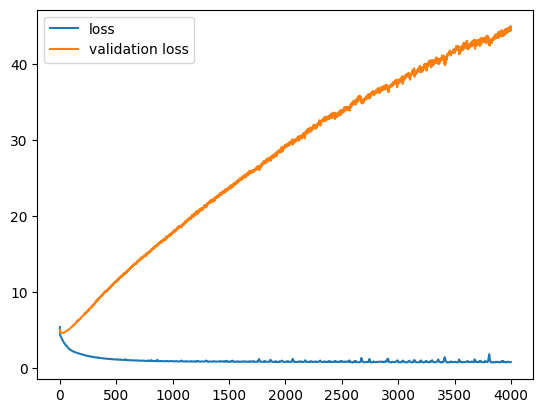

In [27]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

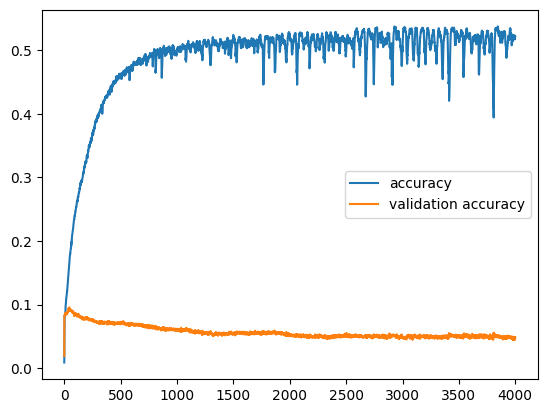

In [28]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [29]:
### 1) Trained the language model to predict the next word in the sentence by memorizing a bunch of sentences.
### 2) Using this trained language model, I will be generating new sentences, poetry

### Decoder

In [63]:
input2 = Input(shape=(1,))

x = embedding_layer(input2)

x, h, c = lstm(x, initial_state=[input_h, input_c])

output2 = dense(x)

sampling_model = Model([input2, input_h, input_c], [output2, h, c])


#### Index to word mapping

In [64]:
idx_to_word = {idx:w for w, idx in word_to_index.items()}
idx_to_word

{1: '<sos>',
 2: '<eos>',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'i',
 7: 'a',
 8: 'of',
 9: 'in',
 10: 'you',
 11: 'it',
 12: 'he',
 13: 'that',
 14: 'was',
 15: 'for',
 16: 'but',
 17: 'as',
 18: 'on',
 19: 'with',
 20: 'what',
 21: 'all',
 22: 'they',
 23: 'had',
 24: 'one',
 25: 'me',
 26: 'his',
 27: 'be',
 28: 'if',
 29: 'have',
 30: 'we',
 31: 'not',
 32: 'is',
 33: 'from',
 34: 'she',
 35: 'up',
 36: 'out',
 37: 'like',
 38: 'see',
 39: 'or',
 40: 'where',
 41: 'at',
 42: 'no',
 43: 'when',
 44: 'my',
 45: 'her',
 46: 'so',
 47: 'by',
 48: 'some',
 49: "it's",
 50: 'him',
 51: "don't",
 52: 'them',
 53: 'this',
 54: 'were',
 55: 'there',
 56: 'been',
 57: 'can',
 58: 'too',
 59: 'are',
 60: 'tell',
 61: "he's",
 62: 'do',
 63: 'old',
 64: "'i",
 65: 'could',
 66: 'know',
 67: 'down',
 68: 'here',
 69: 'an',
 70: 'off',
 71: 'your',
 72: 'think',
 73: 'must',
 74: 'only',
 75: 'make',
 76: 'let',
 77: 'just',
 78: 'come',
 79: 'will',
 80: 'would',
 81: 'way',
 82: 'made',
 83: 'sa

In [68]:
np_input = np.array([[word_to_index['<sos>']]])
h = np.zeros((1, LATENT_DIM))
c = np.zeros((1, LATENT_DIM)) 

eos = word_to_index['<eos>']

output_sentence = []

for _ in range(max_seq_len):
    o, h, c = sampling_model.predict([np_input, h, c])
    print("o.shape:", o.shape, o[0,0,:10])
    idx = np.argmax(o[0,0])
    

1/1 [==============================] - 0s 20ms/step
o.shape: (1, 1, 3000) [3.9492779e-24 5.0539790e-24 6.1222472e-09 5.7555754e-02 2.9371494e-02
 1.1103646e-01 7.4778758e-02 2.0312779e-02 1.8785104e-02 1.9112397e-02]
1/1 [==============================] - 0s 21ms/step
o.shape: (1, 1, 3000) [0.0000000e+00 0.0000000e+00 7.3119646e-22 3.0645410e-08 7.9289485e-08
 4.9732976e-06 3.9475648e-07 6.3280716e-08 6.4839377e-11 6.0013821e-09]
1/1 [==============================] - 0s 18ms/step
o.shape: (1, 1, 3000) [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.5974937e-25 3.7966966e-26
 3.1463340e-27 4.0658661e-21 8.5556421e-23 4.2497917e-28 1.4047435e-31]
1/1 [==============================] - 0s 19ms/step
o.shape: (1, 1, 3000) [0.0000000e+00 0.0000000e+00 6.2203267e-33 1.0244888e-21 5.7044630e-16
 2.6342099e-28 2.1996240e-19 4.3498611e-20 4.0502819e-27 9.6142574e-33]
1/1 [==============================] - 0s 19ms/step
o.shape: (1, 1, 3000) [0.0000000e+00 0.0000000e+00 0.0000000e+00 4.8098334e-32 2

In [67]:
np_input

array([[1]])